## Car Damage Recognition - Inference Test

### Import packages

In [15]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
import re

# from code2.src.Models import Unet

In [16]:
%run -i "../code/src/Models.py"

### Load test datasets

In [17]:
root_dir = os.path.dirname(os.getcwd())
root_dir

'/home/test'

In [18]:
df = pd.read_csv(os.path.join(root_dir, 'code/damage_labeling_new.csv'))
df_test = df[df['dataset'] == 'test']
df_test

,index,Scratched,total_anns,Crushed,Separated,Breakage,dataset
12,0411451_as-0061733.jpg,4.0,4.0,0.0,0.0,0.0,test
15,0487571_sc-228238.jpg,3.0,4.0,0.0,0.0,1.0,test
18,0179291_sc-1021790.jpg,1.0,2.0,0.0,1.0,0.0,test
40,0380126_sc-214161.jpg,3.0,3.0,0.0,0.0,0.0,test
44,0421097_as-0055191.jpg,1.0,1.0,0.0,0.0,0.0,test
...,...,...,...,...,...,...,...
402089,0093122_as-0051088.jpg,2.0,2.0,0.0,0.0,0.0,test
402095,0249014_as-0095155.jpg,3.0,7.0,1.0,2.0,1.0,test
402097,0223656_sc-144460.jpg,4.0,7.0,1.0,2.0,0.0,test
402104,0375607_sc-201451.jpg,0.0,1.0,1.0,0.0,0.0,test


In [19]:
# 향후 편한 코드 실행을 위해 테스트 데이터셋 map 생성
labels = ['Breakage_3', 'Crushed_2', 'Scratch_0', 'Seperated_1']

sample_dataset = {}
for label in labels:
    label_fixed = re.sub(r'_[0-9]', '', label)
    label_fixed = label_fixed.replace('Scratch', 'Scratched').replace('Seperated', 'Separated')
    tmp = df_test.loc[df_test[df_test[label_fixed] > 1.0].sample(n=5).index]
    sample_dataset[label] = tmp['index'].values.tolist()

tmp = df_test.loc[df_test[df_test['total_anns'] > 8.0].sample(n=5).index]
sample_dataset['all'] = tmp['index'].values.tolist()

sample_dataset

{'Breakage_3': ['0371513_sc-122717.jpg',
  '0483690_as-0090125.jpg',
  '0037895_sc-1039630.jpg',
  '0304661_as-7680388.jpg',
  '0261542_sc-202539.jpg'],
 'Crushed_2': ['0311729_sc-182829.jpg',
  '0398840_sc-218685.jpg',
  '0073130_as-0091425.jpg',
  '0229881_as-0036647.jpg',
  '0348524_sc-1021990.jpg'],
 'Scratch_0': ['0497174_as-7962919.jpg',
  '0190792_as-0033757.jpg',
  '0263680_sc-176464.jpg',
  '0186551_sc-222782.jpg',
  '0062596_sc-152721.jpg'],
 'Seperated_1': ['0298054_sc-219199.jpg',
  '0319362_sc-1034462.jpg',
  '0082368_sc-136945.jpg',
  '0378122_as-0062438.jpg',
  '0244681_as-0046951.jpg'],
 'all': ['0425929_sc-202078.jpg',
  '0367415_sc-210981.jpg',
  '0197163_sc-142009.jpg',
  '0129297_sc-224472.jpg',
  '0443663_sc-187208.jpg']}

### Set test mode

In [20]:
test_mode = labels[0]

### Load single model

- `[DAMAGE][Scratch_0]Unet.pt` : 스크래치
- `[DAMAGE][Seperated_1]Unet.pt` : 이격
- `[DAMAGE][Crushed_2]Unet.pt` : 찌그러짐
- `[DAMAGE][Breakage_3]Unet.pt` : 파손

In [51]:
weight_dir = 'data/pretrained_weight/'

weight_file = f'[DAMAGE][{test_mode}]Unet.pt'
# weight_file = '[DAMAGE][Scratch_0]Unet.pt'
# weight_file = '[DAMAGE][Seperated_1]Unet.pt'
# weight_file = '[DAMAGE][Crushed_2]Unet.pt'
# weight_file = '[DAMAGE][Breakage_3]Unet.pt'
weight_file = '[PART]Unet.pt'
weight_path = os.path.join(root_dir, weight_dir, weight_file)

n_classes = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
model.model.load_state_dict(torch.load(weight_path, map_location=torch.device(device)))
model.eval()

print(f'Loaded pretrained model! {weight_file}')

Loaded pretrained model! [PART]Unet.pt


In [52]:
model

Unet(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2

### Load a sample image

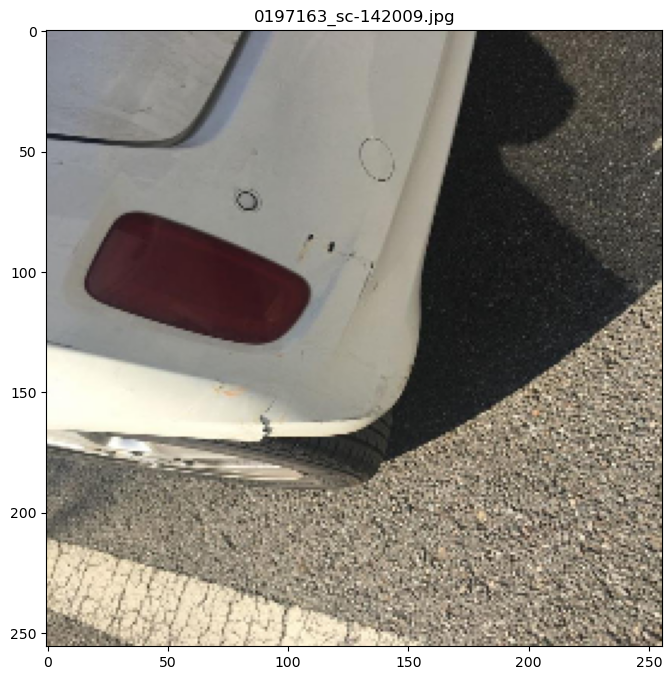

In [53]:
img_dir = 'data/Dataset/1.원천데이터/damage/'

img_file = sample_dataset[test_mode][2]
# img_file = '0093122_as-0051088.jpg'  # Scratched
# img_file = '0249014_as-0095155.jpg'  # Seperated

img_path = os.path.join(root_dir, img_dir, img_file)

img  = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

plt.figure(figsize=(8, 8))
plt.title(img_file)
plt.imshow(img)

### Image pre-processing

In [54]:
img_input = img / 255.
img_input = img_input.transpose([2, 0, 1])
img_input = torch.tensor(img_input).float().to(device)
img_input = img_input.unsqueeze(0)

img_input.shape

torch.Size([1, 3, 256, 256])

### Inference

In [55]:
output = model(img_input)

output.shape

torch.Size([1, 16, 256, 256])

### Post-processing and plot predicted segment

In [90]:
for i in range(n_classes):
    out = output[:,i,:,:]
    i_out = out.unsqueeze(1)
    i_out = torch.argmax(out, dim=1).detach().cpu().numpy()

torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])
0 65020
torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])
1 65029
torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])
2 56385
torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])
3 65023
torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])
4 65020
torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])
5 64517
torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])
6 54829
torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])
7 65024
torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])
8 64769
torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])
9 64516
torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])
10 64303
torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])
11 57224
torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])
12 64896
torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])
13 64028
torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])
14 2133
torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 25

torch.Size([1, 16, 256, 256])
(1, 256, 256)
(256, 256, 1)


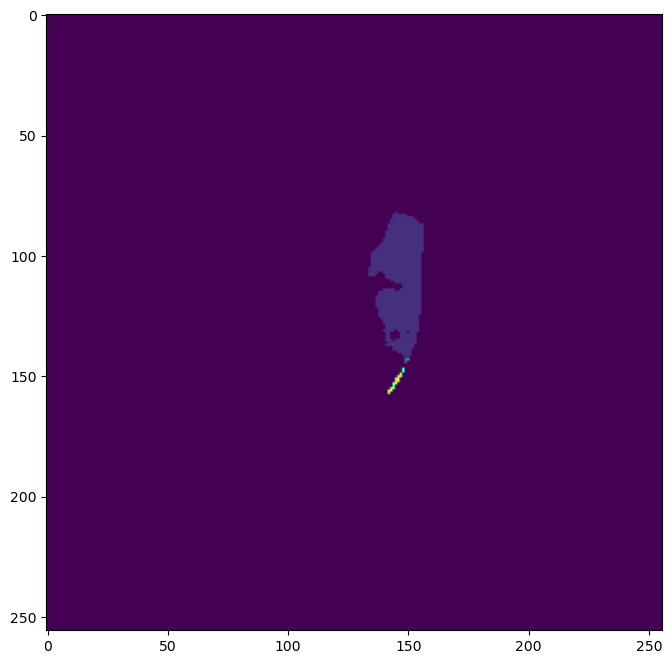

In [83]:
print(output.shape)
img_output = torch.argmax(output, dim=1).detach().cpu().numpy()
print(img_output.shape)
img_output = img_output.transpose([1, 2, 0])
print(img_output.shape)

plt.figure(figsize=(8, 8))
plt.imshow(img_output)

In [80]:
img_output

array([], shape=(0, 256, 1), dtype=int64)

In [78]:
# segmented pixel count
img_output.shape, img_output.sum()

((256, 256, 1), 2078)

### Final result plot

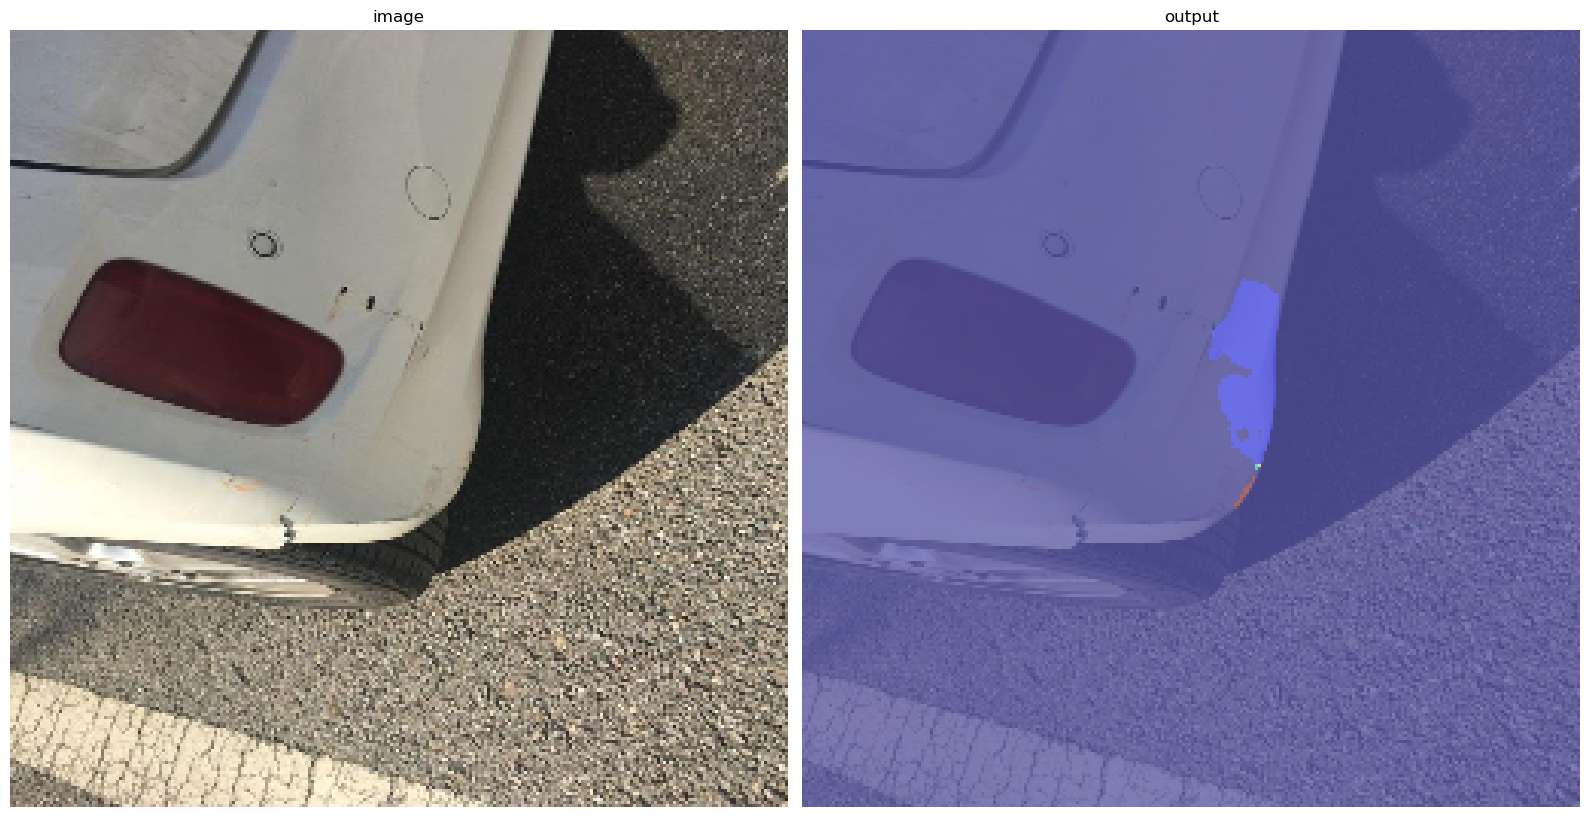

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

ax[0].imshow(img)
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(img.astype('uint8'), alpha=0.5)
ax[1].imshow(img_output, cmap='jet', alpha=0.5)
ax[1].set_title('output')
ax[1].axis('off')

fig.set_tight_layout(True)
plt.show()

### 여러 형태의 파손 영역 감지

In [46]:
test_mode = 'all'
models = []

n_classes = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for label in labels:
    # model_path = f'models/[DAMAGE][{label}]Unet.pt'
    model_path = os.path.join(root_dir, weight_dir, f'[DAMAGE][{label}]Unet.pt')

    model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
    model.model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()

    models.append(model)

print('Loaded all pretrained models!')

Loaded all pretrained models!


### Load sample image

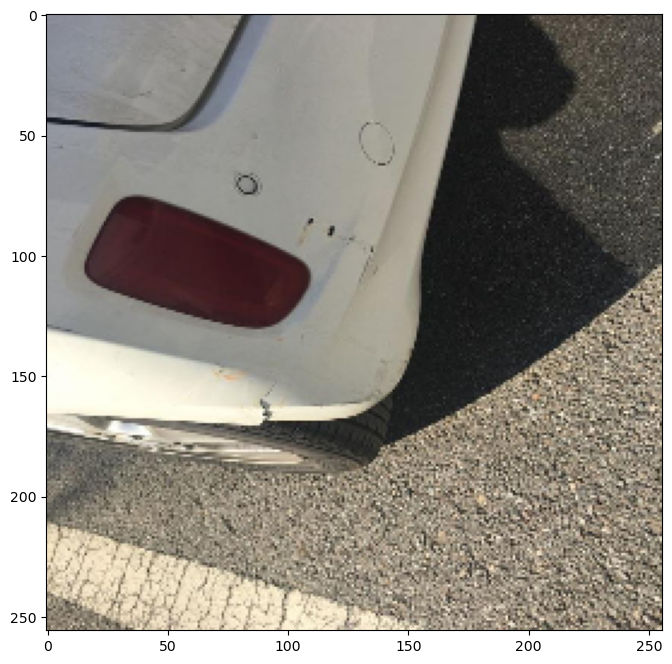

In [47]:
# img_file = '0067189_sc-104786.jpg'
img_file = sample_dataset[test_mode][2]
img_path = os.path.join(root_dir, img_dir, img_file)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

plt.figure(figsize=(8, 8))
plt.imshow(img)

### Inference all models and plot results

NameError: name 'models' is not defined

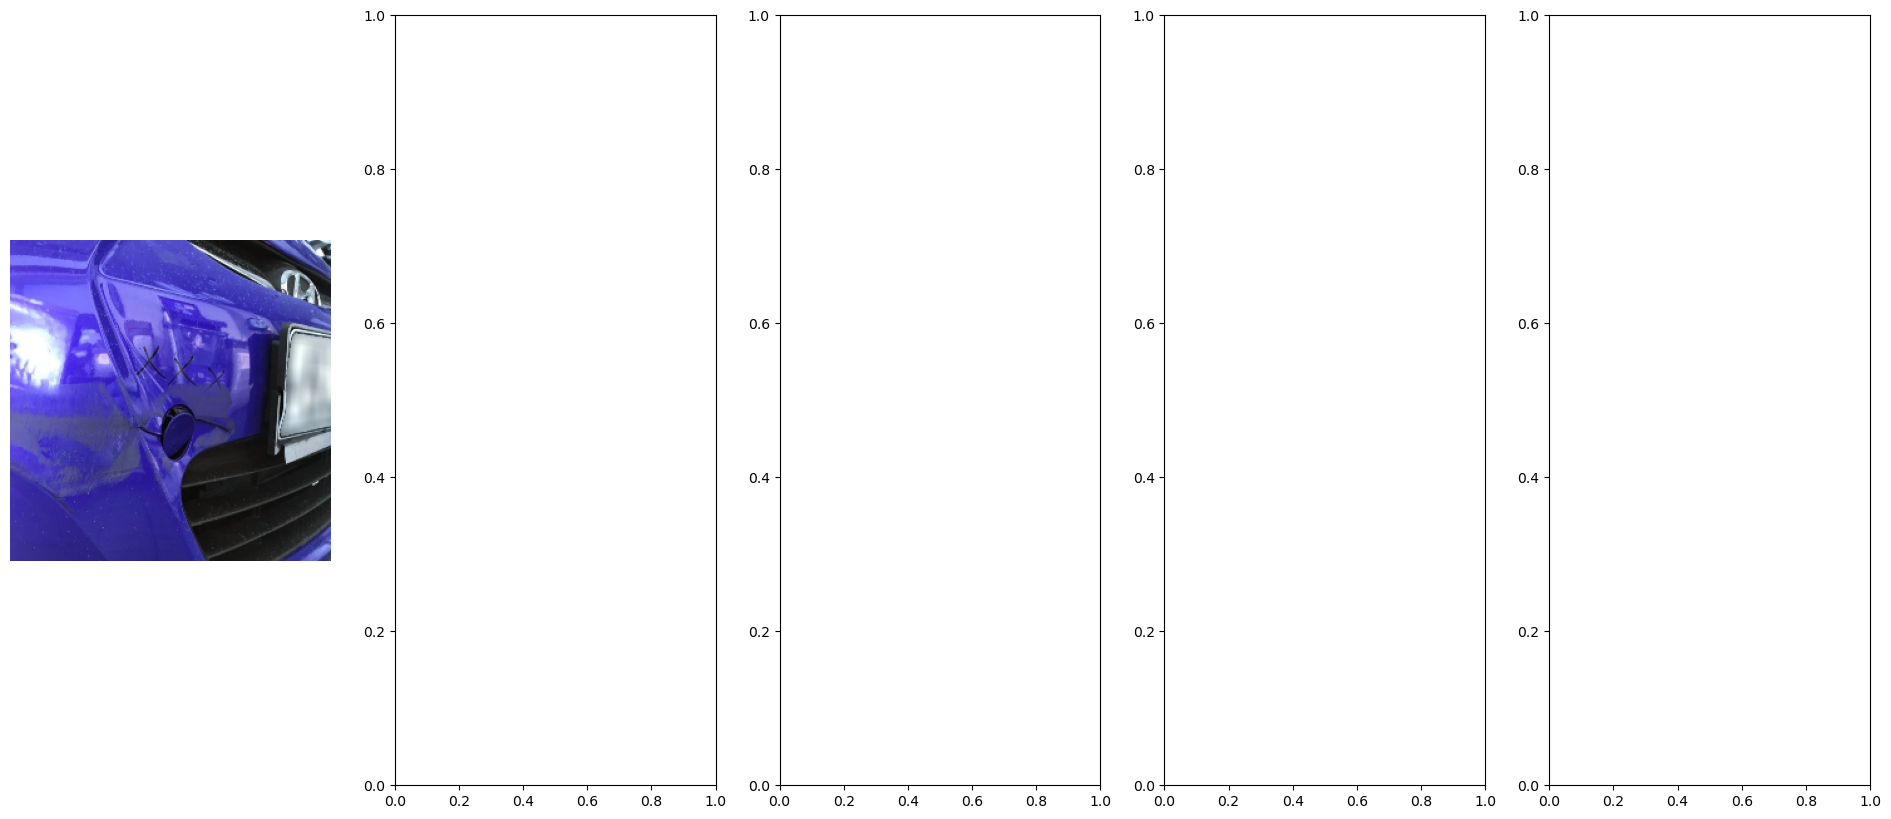

In [39]:
img_input = img / 255.
img_input = img_input.transpose([2, 0, 1])
img_input = torch.tensor(img_input).float().to(device)
img_input = img_input.unsqueeze(0)

fig, ax = plt.subplots(1, 5, figsize=(24, 10))

ax[0].imshow(img)
ax[0].axis('off')

outputs = []

for i, model in enumerate(models):
    output = model(img_input)

    img_output = torch.argmax(output, dim=1).detach().cpu().numpy()
    img_output = img_output.transpose([1, 2, 0])

    outputs.append(img_output)

    ax[i+1].set_title(labels[i])
    ax[i+1].imshow(img_output, cmap='jet')
    ax[i+1].axis('off')

fig.set_tight_layout(True)
plt.show()

### Calculate the area of damages

In [98]:
# 픽셀 수 합산
for i, label in enumerate(labels):
    print(f'{label}: {outputs[i].sum()}')

Breakage_3: 591
Crushed_2: 0
Scratch_0: 615
Seperated_1: 1029


### 파손 영역 크기에 따른 가격 산출 (예시)

1픽셀당 가격을 책정하여 영역이 넓을 수록 수리비용이 비싸진다

In [63]:
price_table = [
    100, # Breakage_3
    200, # Crushed_2
    50,  # Scratch_0
    120, # Seperated_1
]

total = 0

for i, price in enumerate(price_table):
    area = outputs[i].sum()
    total += area * price

    print(f'{labels[i]}:\t영역: {area}\t가격:{area * price}원')

print(f'빵형 고객님, 총 수리비는 {total}원 입니다!')

Breakage_3:	영역: 223	가격:22300원
Crushed_2:	영역: 0	가격:0원
Scratch_0:	영역: 306	가격:15300원
Seperated_1:	영역: 2466	가격:295920원
빵형 고객님, 총 수리비는 333520원 입니다!


### Reference
- 유튜브 [빵형의 개발도상국](https://www.youtube.com/channel/UC9PB9nKYqKEx_N3KM-JVTpg)